<a href="https://colab.research.google.com/github/nguyen-nhat-mai/ensemble_project/blob/main/Airbnb_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [4]:
! pip install kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
! kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data

  0% 0.00/2.44M [00:00<?, ?B/s]
100% 2.44M/2.44M [00:00<00:00, 171MB/s]


In [6]:
! unzip /content/new-york-city-airbnb-open-data.zip

Archive:  /content/new-york-city-airbnb-open-data.zip
  inflating: AB_NYC_2019.csv         
  inflating: New_York_City_.png      


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# **Data Exploration**

**Initial check**

In [51]:
# load dataset
df = pd.read_csv('/content/AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [9]:
df.shape

(48895, 16)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [14]:
# check null value
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [15]:
# check duplicate
df.duplicated().sum()

0

In [16]:
# check numerical variables
num_var = ['latitude','longitude','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365','price']
df[num_var].describe()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price
count,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,7.029962,23.274466,1.373221,7.143982,112.781327,152.720687
std,0.054530,0.046157,20.510550,44.550582,1.680442,32.952519,131.622289,240.154170
min,40.499790,-74.244420,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,40.690100,-73.983070,1.000000,1.000000,0.190000,1.000000,0.000000,69.000000
50%,40.723070,-73.955680,3.000000,5.000000,0.720000,1.000000,45.000000,106.000000
75%,40.763115,-73.936275,5.000000,24.000000,2.020000,2.000000,227.000000,175.000000
max,40.913060,-73.712990,1250.000000,629.000000,58.500000,327.000000,365.000000,10000.000000


In [17]:
# check categorical variables (unique values, format consistency such as lower/uppercase, space,...)
print('Unique values per variable')
print(df[['name','host_name','neighbourhood_group','neighbourhood','room_type']].nunique())
print('\nUnique values in neighbourhood_group', df['neighbourhood_group'].unique())
print('Unique values in room_type', df['room_type'].unique())

Unique values per variable
name                   47905
host_name              11452
neighbourhood_group        5
neighbourhood            221
room_type                  3
dtype: int64

Unique values in neighbourhood_group ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
Unique values in room_type ['Private room' 'Entire home/apt' 'Shared room']


**Target variable: Price**

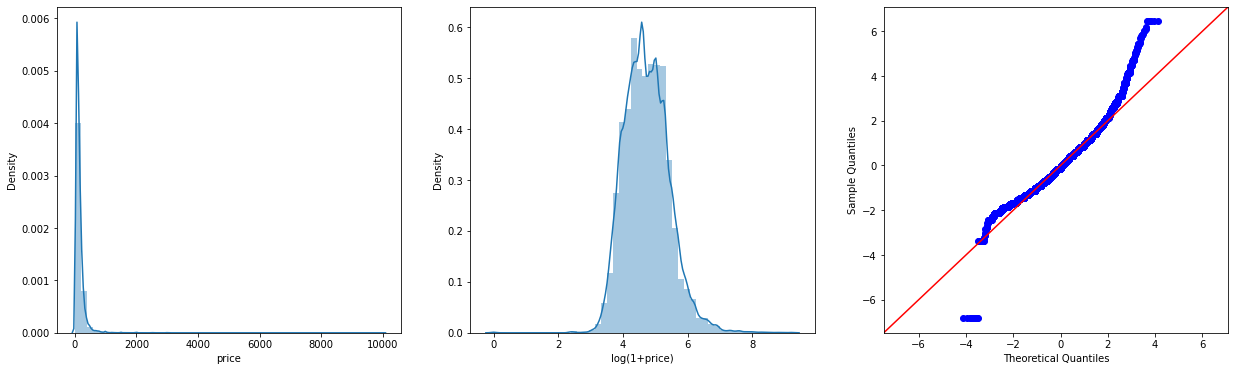

In [18]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(df['price'], ax=axes[0])
sns.distplot(np.log1p(df['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(df['price']), stats.norm, fit=True, line='45', ax=axes[2])
plt.show()

The distribution of price is highly skewed. By taking log, the variable seems to follow normal distribution.

In [19]:
df['log_price'] = np.log1p(df['price'])

**Distribution of other numerical variables**

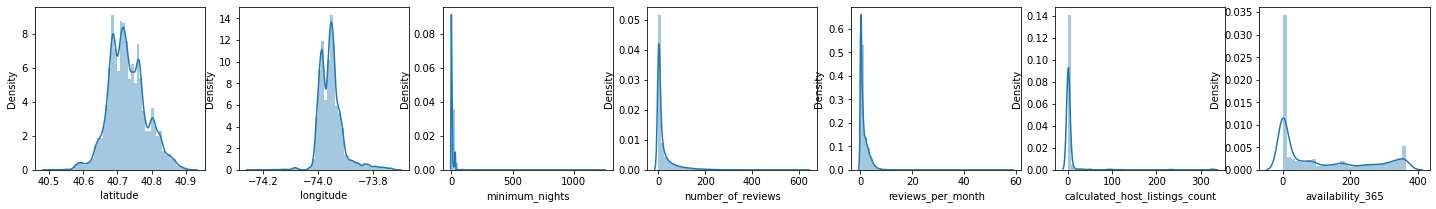

In [20]:
filter_num_var = num_var[:-1] # exclude price
f,ax = plt.subplots(1,7, figsize=(25,3))
for i in range(len(filter_num_var)):
  sns.distplot(df[filter_num_var[i]], ax=ax[i])
  ax[i].set_xlabel(filter_num_var[i])

Except for latitude and longtitude, distributions of the remaining variables are highly skewed

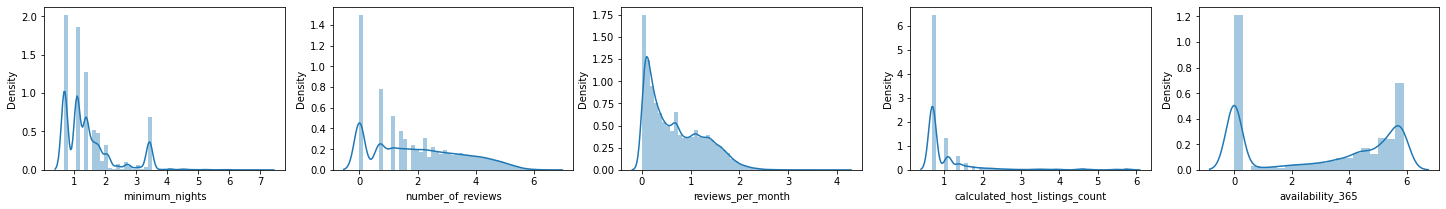

In [21]:
skewed_var = ['minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']
f,ax = plt.subplots(1,5, figsize=(25,3))
for i in range(len(skewed_var)):
  sns.distplot(np.log1p(df[skewed_var[i]]), ax=ax[i])
  ax[i].set_xlabel(skewed_var[i])

The data are too skewed that log transformation can not normalize the them. However, we can add these as potential features for trial & error in modeling part.

In [22]:
# Add log variables
df['log_minimum_nights'] = np.log1p(df['minimum_nights'])
df['log_number_of_reviews'] = np.log1p(df['number_of_reviews'])
df['log_reviews_per_month'] = np.log1p(df['reviews_per_month'])
df['log_calculated_host_listings_count'] = np.log1p(df['calculated_host_listings_count'])
df['log_availability_365'] = np.log1p(df['availability_365'])

Besides, since the variables are highly concentrated in certain values, other yes/no features such as no_review, fully_available, low_available, etc. can be extracted for trial and error as well.

In [23]:
# Add yes/no (1/0) variables
df['no_review'] = np.where(df['reviews_per_month'] > 0, 0, 1) # place without a review
df['minimum_night_1'] = np.where(df['minimum_nights'] == 1, 1, 0) # places requires minimum night of 1
df['host_listing_1'] = np.where(df['calculated_host_listings_count'] == 1, 1, 0) # host list only 1 place
df['availability_full'] = np.where(df['availability_365'] == 365, 1, 0) # availability = 365
df['availability_low'] = np.where(df['availability_365'] < 12, 1, 0) # available less than 1 day/month
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,log_minimum_nights,log_number_of_reviews,log_reviews_per_month,log_calculated_host_listings_count,log_availability_365,no_review,minimum_night_1,host_listing_1,availability_full,availability_low
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,0.693147,2.302585,0.190620,1.945910,5.902633,0,1,0,1,0
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,0.693147,3.828641,0.322083,1.098612,5.874931,0,1,0,0,0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,...,1.386294,0.000000,NaN,0.693147,5.902633,1,0,1,1,0
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,0.693147,5.602119,1.729884,0.693147,5.273000,0,1,1,0,0
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,2.397895,2.302585,0.095310,0.693147,0.000000,0,0,1,0,1


**A map view of price distribution**

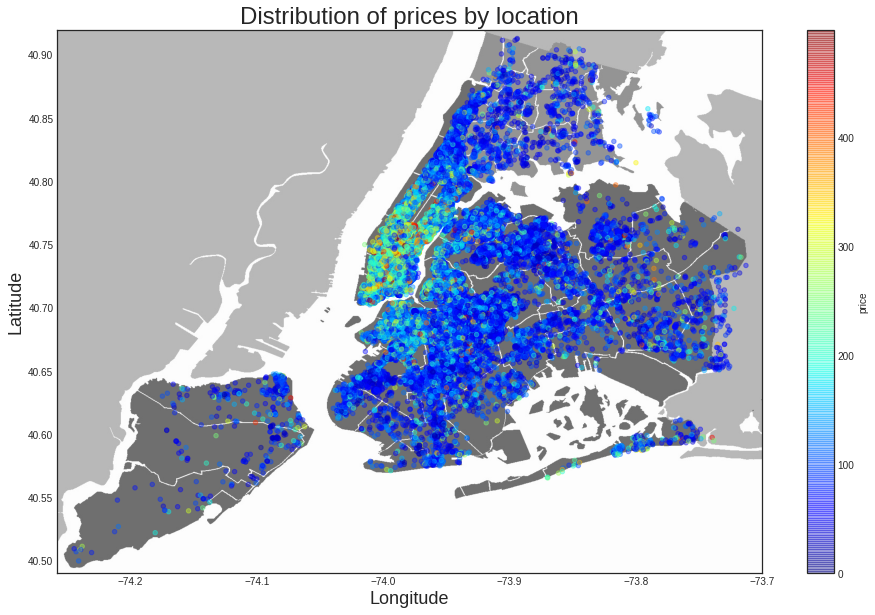

In [39]:
plt.figure(figsize=(16,10))
nyc_img=plt.imread("/content/New_York_City_.png", 0) #without the 0 we get an "invalid png header" error

#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()

#using scatterplot
df[df.price < 500].plot(kind='scatter', x='longitude', y='latitude', c='price', ax=ax, 
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)
plt.legend()
plt.title('Distribution of prices by location', fontsize= 24)
plt.xlabel('Longitude', fontsize = 18)
plt.ylabel('Latitude', fontsize = 18)

plt.show()

**A map view of the availability**

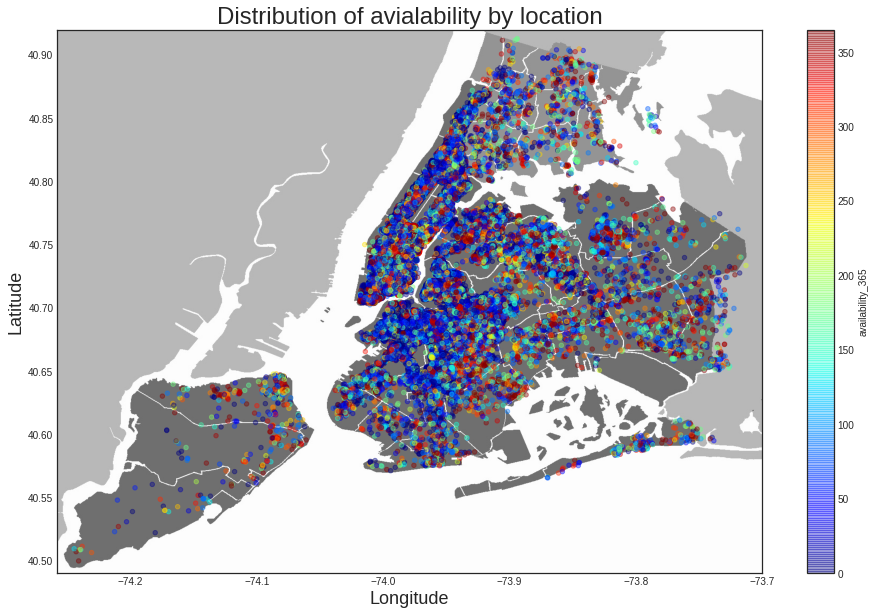

In [40]:
plt.figure(figsize=(16,10))
nyc_img=plt.imread("/content/New_York_City_.png", 0) #without the 0 we get an "invalid png header" error

#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()

#using scatterplot
df[df.availability_365>= 0].plot(kind='scatter', x='longitude', y='latitude', c='availability_365', ax=ax, 
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)
plt.legend()
plt.title('Distribution of avialability by location', fontsize=24)
plt.xlabel('Longitude', fontsize = 18)
plt.ylabel('Latitude', fontsize = 18)
plt.show()

**Neighbourhood Groups**

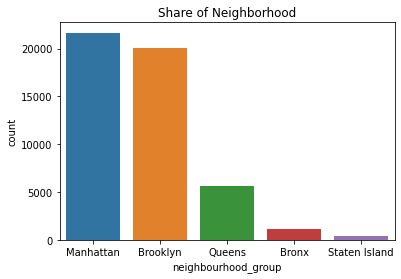

In [25]:
# visualize the number of Airbnbs in each borough
ax = sns.countplot('neighbourhood_group',data=df,order=df['neighbourhood_group'].value_counts().index)
ax.set_title('Share of Neighborhood')
plt.show()

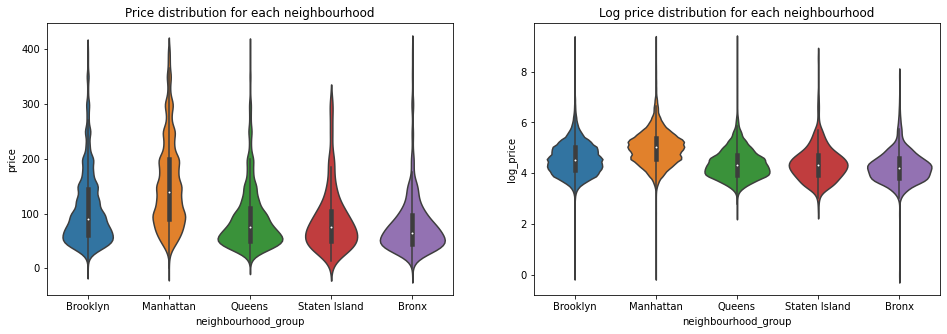

In [26]:
# create a sub-dataframe with no extreme values /
winsorized_df = df[df.price < 400]

# using violinplot to showcase density and distribtuion of prices
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.violinplot(data=winsorized_df, x='neighbourhood_group', y='price', ax=ax[0])
ax[0].set_title('Price distribution for each neighbourhood')
sns.violinplot(data=df, x='neighbourhood_group', y='log_price', ax=ax[1])
ax[1].set_title('Log price distribution for each neighbourhood')
plt.show()

We can see that Manhattan seems to have more of the higher priced properties. Bronx, Staten Island, and Queens have much more reasonable prices compared to Brooklyn and Manhattan. All distributions of price have positive skew while distributions of log(price) are quite normal.

**Room Type**

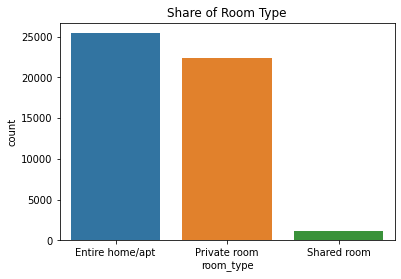

In [27]:
ax = sns.countplot('room_type',data=df,order=df['room_type'].value_counts().index)
ax.set_title('Share of Room Type')
plt.show()

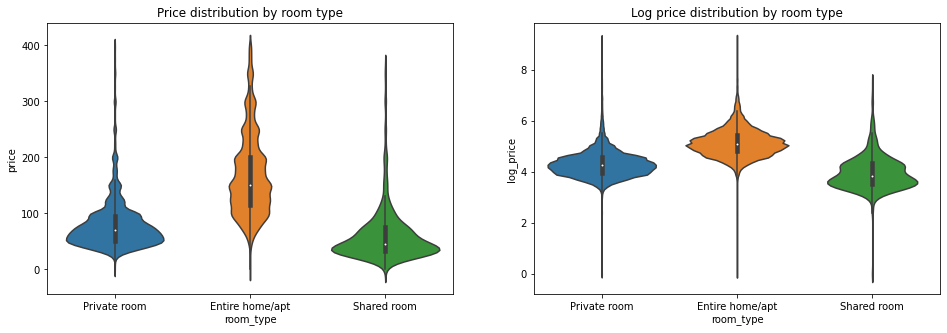

In [28]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.violinplot(data=winsorized_df, x='room_type', y='price',ax=ax[0])
ax[0].set_title('Price distribution by room type')
sns.violinplot(data=df, x='room_type', y='log_price',ax=ax[1])
ax[1].set_title('Log price distribution by room type')
plt.show()

As expected, shared rooms have the lowest mean price, while entire homes have the highest. All room types seem to have a similar spread, however private rooms and shared rooms seemd to be more centered around their mean. There is more disparity of price with entire homes.

**Variable Correlations**

In [29]:
df.corr().style.background_gradient(cmap='coolwarm')

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_price,log_minimum_nights,log_number_of_reviews,log_reviews_per_month,log_calculated_host_listings_count,log_availability_365,no_review,minimum_night_1,host_listing_1,availability_full,availability_low
id,1.000000,0.588290,-0.003125,0.090908,0.010619,-0.013224,-0.319760,0.291828,0.133272,0.085468,-0.015395,-0.025579,-0.318417,0.335457,0.148125,0.185801,0.164785,0.047127,-0.117694,0.005779,-0.197884
host_id,0.588290,1.000000,0.020224,0.127055,0.015309,-0.017364,-0.140106,0.296417,0.154950,0.203492,-0.016690,-0.064221,-0.130489,0.321223,0.181872,0.248474,0.084543,0.124534,-0.140426,0.037615,-0.238412
latitude,-0.003125,0.020224,1.000000,0.084788,0.033939,0.024869,-0.015389,-0.010142,0.019517,-0.010983,0.079339,0.032987,-0.029572,-0.015862,0.032135,-0.015589,0.029387,0.020154,0.014829,0.000198,0.019058
longitude,0.090908,0.127055,0.084788,1.000000,-0.150019,-0.062747,0.059094,0.145948,-0.114713,0.082731,-0.325043,-0.126381,0.080434,0.144023,-0.042160,0.108411,-0.043506,0.108033,-0.105213,0.031785,-0.107916
price,0.010619,0.015309,0.033939,-0.150019,1.000000,0.042799,-0.047954,-0.030608,0.057472,0.081829,0.637669,0.047771,-0.075871,-0.027814,0.035429,0.070384,0.085151,-0.026415,0.034611,0.067343,-0.059028
minimum_nights,-0.013224,-0.017364,0.024869,-0.062747,0.042799,1.000000,-0.080116,-0.121702,0.127960,0.144303,0.033185,0.629890,-0.123265,-0.139462,0.187882,0.117511,0.111360,-0.174334,-0.074065,0.101087,-0.096201
number_of_reviews,-0.319760,-0.140106,-0.015389,0.059094,-0.047954,-0.080116,1.000000,0.549868,-0.072376,0.172028,-0.042801,-0.167118,0.760307,0.573541,-0.050196,0.253646,-0.265767,0.078097,-0.089469,-0.048330,-0.253268
reviews_per_month,0.291828,0.296417,-0.010142,0.145948,-0.030608,-0.121702,0.549868,1.000000,-0.009421,0.185791,-0.039487,-0.285968,0.578669,0.935956,0.018588,0.335710,nan,0.239697,-0.128453,-0.047865,-0.350789
calculated_host_listings_count,0.133272,0.154950,0.019517,-0.114713,0.057472,0.127960,-0.072376,-0.009421,1.000000,0.225701,0.132274,0.246309,-0.121799,0.000056,0.782973,0.179575,0.118088,-0.084971,-0.260158,0.030105,-0.141722
availability_365,0.085468,0.203492,-0.010983,0.082731,0.081829,0.144303,0.172028,0.185791,0.225701,1.000000,0.098558,0.178339,0.171066,0.236762,0.398314,0.863923,-0.031387,0.001632,-0.359167,0.316070,-0.717890


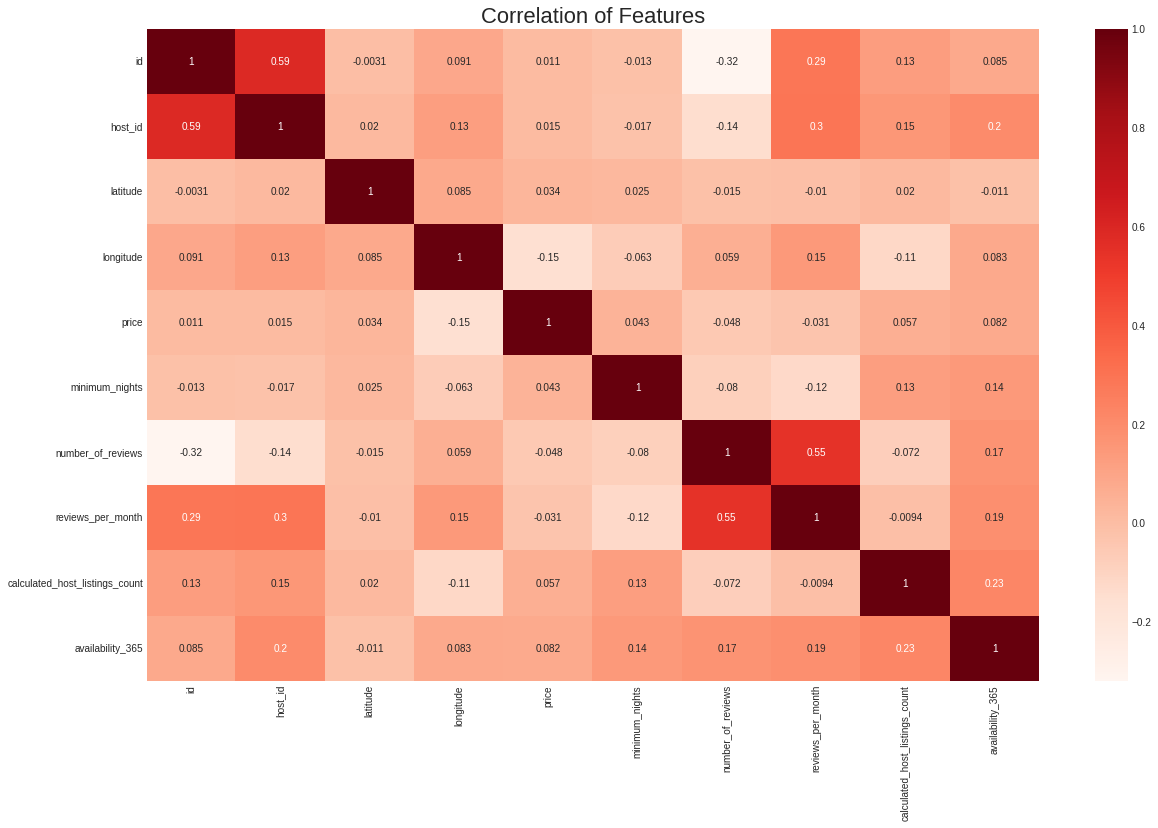

In [41]:
plt.figure(figsize=(20,12))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.title("Correlation of Features", fontsize = 22)
plt.show()

# **Data Pre-processing**

**Deal with missing values**

In [52]:
# impute the null values in reviews_per_month with zero
df['reviews_per_month'].fillna(value=0, inplace=True)
print('Reviews_per_month column with null values:',df['reviews_per_month'].isnull().sum(), sep = '\n')

Reviews_per_month column with null values:
0


In [53]:
# drop unwwanted features
df.drop(['id','host_name','last_review'], axis = 1,inplace=True) 
df.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


**Deal with outliers**

Text(0.5, 1.0, 'reviews_per_month')

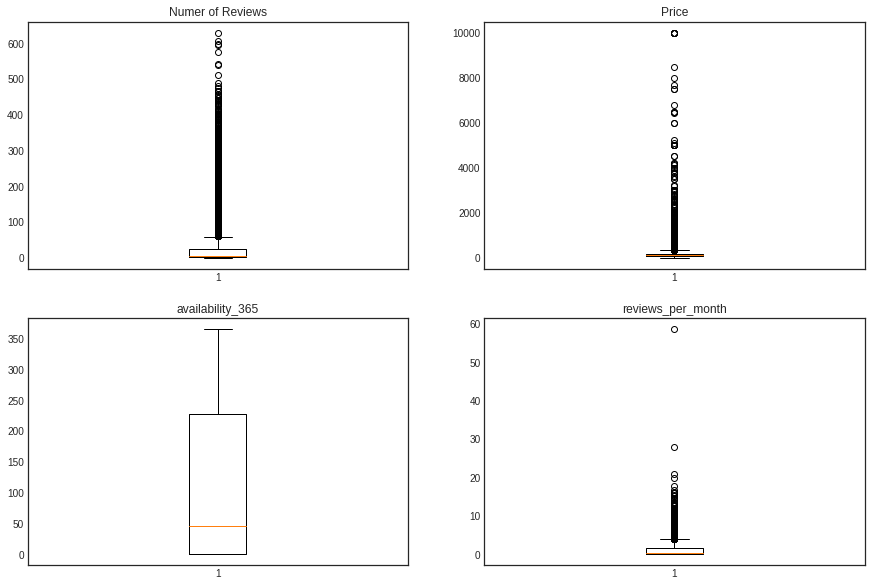

In [54]:
# visualize data and check outliers
plt.figure(figsize = (15, 10))
plt.style.use('seaborn-white')
ax=plt.subplot(221)
plt.boxplot(df['number_of_reviews'])
ax.set_title('Numer of Reviews')
ax=plt.subplot(222)
plt.boxplot(df['price'])
ax.set_title('Price')
ax=plt.subplot(223)
plt.boxplot(df['availability_365'])
ax.set_title('availability_365')
ax=plt.subplot(224)
plt.boxplot(df['reviews_per_month'])
ax.set_title('reviews_per_month')

We can see that except availability_365 all other numerical factors have the huge amount of outliers.

In [55]:
# remove outliers 
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
filter = (df['price'] >= Q1 - 1.5 * IQR) & (df['price'] <= Q3 + 1.5 *IQR)
df1 = df.loc[filter]

Q1 = df1['number_of_reviews'].quantile(0.25)
Q3 = df1['number_of_reviews'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
filter = (df1['number_of_reviews'] >= Q1 - 1.5 * IQR) & (df1['number_of_reviews'] <= Q3 + 1.5 *IQR)
df2 = df1.loc[filter]

Q1 = df2['reviews_per_month'].quantile(0.25)
Q3 = df2['reviews_per_month'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
filter = (df2['reviews_per_month'] >= Q1 - 1.5 * IQR) & (df2['reviews_per_month'] <= Q3 + 1.5 *IQR)
df_new = df2.loc[filter]

Text(0.5, 1.0, 'reviews_per_month')

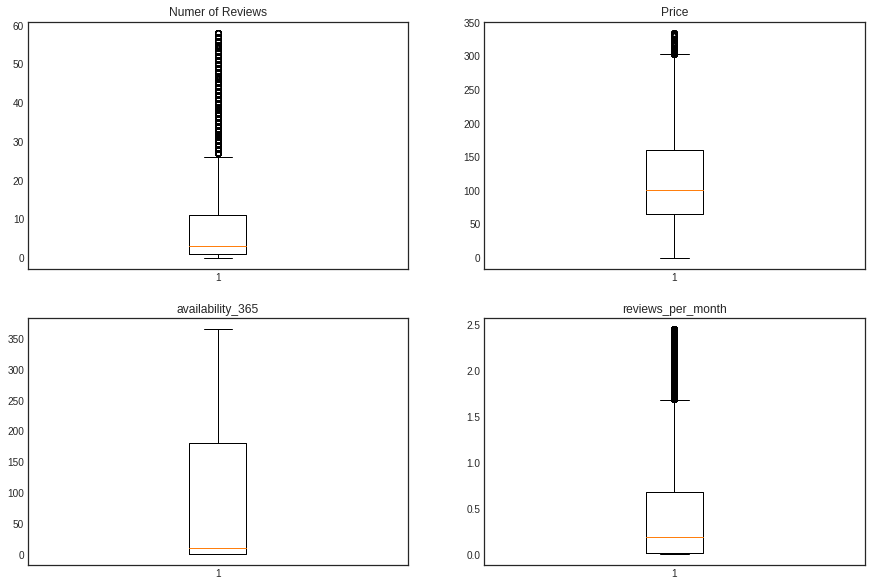

In [56]:
# check outliers again
plt.figure(figsize = (15, 10))
plt.style.use('seaborn-white')
ax=plt.subplot(221)
plt.boxplot(df_new['number_of_reviews'])
ax.set_title('Numer of Reviews')
ax=plt.subplot(222)
plt.boxplot(df_new['price'])
ax.set_title('Price')
ax=plt.subplot(223)
plt.boxplot(df_new['availability_365'])
ax.set_title('availability_365')
ax=plt.subplot(224)
plt.boxplot(df_new['reviews_per_month'])
ax.set_title('reviews_per_month')

In [57]:
# check % data removed ==> remove too much => can use log(price) instead?
1-len(df_new)/len(df)

0.2610696390223949

As can be seen from the graph of log-price distribution above, values in the range of 3 to 8 are the more 'reasonable' data. So we remove the data outside that range.

In [47]:
'''
# remove outliers - log(price) version
df = df[np.log1p(df['price']) < 8]
df = df[np.log1p(df['price']) > 3]
df['log_price'] = np.log1p(df['price'])
'''

We tried to log(price) to remove outliers, but the percentage of remove will be increased from 26% to 38%. As the dataset is big enough, we suppose 26% of remove will be fine for modelling.

**Convert categorical data**

In [ ]:
# one hot encoding
dummy_neighbourhood=pd.get_dummies(df_new['neighbourhood_group'], prefix='dummy')
dummy_roomtype=pd.get_dummies(df_new['room_type'], prefix='dummy')

In [ ]:
col_names = list(df_new.columns)
target_names = {'price', 'log_price'}
feature_names = [ele for ele in col_names if ele not in target_names]
feature_names

['name',
 'host_id',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'log_minimum_nights',
 'log_number_of_reviews',
 'log_reviews_per_month',
 'log_calculated_host_listings_count',
 'log_availability_365',
 'no_review',
 'minimum_night_1',
 'host_listing_1',
 'availability_full',
 'availability_low']

In [ ]:
airbnb_features = df_new[feature_names]
airbnb_features = pd.concat([airbnb_features,dummy_neighbourhood,dummy_roomtype],axis=1)
airbnb_features.drop(['neighbourhood_group','room_type','name','neighbourhood'],axis=1, inplace=True)
airbnb_features

,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_minimum_nights,log_number_of_reviews,...,availability_full,availability_low,dummy_Bronx,dummy_Brooklyn,dummy_Manhattan,dummy_Queens,dummy_Staten Island,dummy_Entire home/apt,dummy_Private room,dummy_Shared room
0,2787,40.64749,-73.97237,1,9,0.21,6,365,0.693147,2.302585,...,1,0,0,1,0,0,0,0,1,0
1,2845,40.75362,-73.98377,1,45,0.38,2,355,0.693147,3.828641,...,0,0,0,0,1,0,0,1,0,0
2,4632,40.80902,-73.94190,3,0,0.00,1,365,1.386294,0.000000,...,1,0,0,0,1,0,0,0,1,0
4,7192,40.79851,-73.94399,10,9,0.10,1,0,2.397895,2.302585,...,0,1,0,0,1,0,0,1,0,0
6,7356,40.68688,-73.95596,45,49,0.40,1,0,3.828641,3.912023,...,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,8232441,40.67853,-73.94995,2,0,0.00,2,9,1.098612,0.000000,...,0,1,0,1,0,0,0,0,1,0
48891,6570630,40.70184,-73.93317,4,0,0.00,2,36,1.609438,0.000000,...,0,0,0,1,0,0,0,0,1,0
48892,23492952,40.81475,-73.94867,10,0,0.00,1,27,2.397895,0.000000,...,0,0,0,0,1,0,0,1,0,0
48893,30985759,40.75751,-73.99112,1,0,0.00,6,2,0.693147,0.000000,...,0,1,0,0,1,0,0,0,0,1


In [ ]:
'''
# Encode labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder() # Fit label encoder
le.fit(df_new['neighbourhood_group'])
df_new['neighbourhood_group']=le.transform(df_new['neighbourhood_group']) # Transform labels to normalized encoding.

le = preprocessing.LabelEncoder()
le.fit(df_new['neighbourhood'])
df_new['neighbourhood']=le.transform(df_new['neighbourhood'])

le = preprocessing.LabelEncoder()
le.fit(df_new['room_type'])
df_new['room_type']=le.transform(df_new['room_type'])

df_new.sort_values(by='price',ascending=True,inplace=True)

df_new.head()
'''

**Standardize the dataset**

In [ ]:
# normalize the data
from sklearn import preprocessing
X = preprocessing.scale(airbnb_features)
y_price = df_new.price
y_log_price = df_new.log_price
print(X)
print(y_price)
print(y_log_price)

[[-0.83740145 -1.48318722 -0.44349298 ... -0.99381927  1.04623811
  -0.16236422]
 [-0.83740068  0.45006534 -0.70217978 ...  1.00621917 -0.95580537
  -0.16236422]
 [-0.83737694  1.45922573  0.2479269  ... -0.99381927  1.04623811
  -0.16236422]
 ...
 [-0.52537494  1.56360278  0.09430325 ...  1.00621917 -0.95580537
  -0.16236422]
 [-0.42584586  0.52092516 -0.86896469 ... -0.99381927 -0.95580537
   6.15899258]
 [ 0.0674163   0.63987493 -0.82834632 ... -0.99381927  1.04623811
  -0.16236422]]
0        149
1        225
2        150
4         80
6         60
        ... 
48890     70
48891     40
48892    115
48893     55
48894     90
Name: price, Length: 36130, dtype: int64
0        5.010635
1        5.420535
2        5.017280
4        4.394449
6        4.110874
           ...   
48890    4.262680
48891    3.713572
48892    4.753590
48893    4.025352
48894    4.510860
Name: log_price, Length: 36130, dtype: float64


In [ ]:
# turn the data into a dataframe
X = pd.DataFrame(X)
col_name_map = {k: v for k, v in enumerate(list(airbnb_features.columns))}
X=X.rename(index=str, columns=col_name_map)
X.head()

,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_minimum_nights,log_number_of_reviews,...,availability_full,availability_low,dummy_Bronx,dummy_Brooklyn,dummy_Manhattan,dummy_Queens,dummy_Staten Island,dummy_Entire home/apt,dummy_Private room,dummy_Shared room
0,-0.837401,-1.483187,-0.443493,-0.320128,0.059627,-0.411679,-0.044326,2.057729,-0.987560,0.667073,...,5.911874,-1.012758,-0.145597,1.166344,-0.881923,-0.353581,-0.083641,-0.993819,1.046238,-0.162364
1,-0.837401,0.450065,-0.702180,-0.320128,3.028170,-0.123768,-0.165507,1.981041,-0.987560,1.920811,...,-0.169151,-1.012758,-0.145597,-0.857380,1.133885,-0.353581,-0.083641,1.006219,-0.955805,-0.162364
2,-0.837377,1.459226,0.247927,-0.229099,-0.682508,-0.767335,-0.195802,2.057729,-0.229826,-1.224624,...,5.911874,-1.012758,-0.145597,-0.857380,1.133885,-0.353581,-0.083641,-0.993819,1.046238,-0.162364
3,-0.837343,1.267777,0.200501,0.089500,0.059627,-0.597975,-0.195802,-0.741363,0.876036,0.667073,...,-0.169151,0.987403,-0.145597,-0.857380,1.133885,-0.353581,-0.083641,1.006219,-0.955805,-0.162364
4,-0.837341,-0.765663,-0.071120,1.682500,3.358008,-0.089896,-0.195802,-0.741363,2.440099,1.989313,...,-0.169151,0.987403,-0.145597,1.166344,-0.881923,-0.353581,-0.083641,-0.993819,1.046238,-0.162364


From this dataframe, team modeling can take any set of features they want to test with the models? (trial and error)

**other pre-processing (optional)**

We can find that 'reviews_per_month' and 'number of reviews' are not that helpful for our prediction as these two features will occur only after the purchase(stay) gets over.

In [ ]:
# drop leaky predictors from dataset
potential_leaks = ['reviews_per_month','number_of_reviews']
X2 = X.drop(potential_leaks, axis=1)
X2

,availability_365,minimum_nights,calculated_host_listings_count,dummy_Bronx,dummy_Brooklyn,dummy_Manhattan,dummy_Queens,dummy_Staten Island,dummy_Entire home/apt,dummy_Private room,dummy_Shared room
0,2.057729,-0.320128,-0.044326,-0.145597,1.166344,-0.881923,-0.353581,-0.083641,-0.993819,1.046238,-0.162364
1,1.981041,-0.320128,-0.165507,-0.145597,-0.857380,1.133885,-0.353581,-0.083641,1.006219,-0.955805,-0.162364
2,2.057729,-0.229099,-0.195802,-0.145597,-0.857380,1.133885,-0.353581,-0.083641,-0.993819,1.046238,-0.162364
3,-0.741363,0.089500,-0.195802,-0.145597,-0.857380,1.133885,-0.353581,-0.083641,1.006219,-0.955805,-0.162364
4,-0.741363,1.682500,-0.195802,-0.145597,1.166344,-0.881923,-0.353581,-0.083641,-0.993819,1.046238,-0.162364
...,...,...,...,...,...,...,...,...,...,...,...
36125,-0.672344,-0.274614,-0.165507,-0.145597,1.166344,-0.881923,-0.353581,-0.083641,-0.993819,1.046238,-0.162364
36126,-0.465288,-0.183585,-0.165507,-0.145597,1.166344,-0.881923,-0.353581,-0.083641,-0.993819,1.046238,-0.162364
36127,-0.534307,0.089500,-0.195802,-0.145597,-0.857380,1.133885,-0.353581,-0.083641,1.006219,-0.955805,-0.162364
36128,-0.726026,-0.320128,-0.044326,-0.145597,-0.857380,1.133885,-0.353581,-0.083641,-0.993819,-0.955805,6.158993


# **Modeling**